# PV-Segmentation using torch - Multi Resolution Solar Photovoltaik System Segmentation
Existing deep learning networks for solar photovoltaic system segmentation focus almost exclusively on single image sources, both in terms of sensors used and image resolution. This often prevents the wide deployment of such networks. Our research introduces a novel network trained on a diverse range of image data, spanning UAVs, aerial and satellite imagery at both native and aggregated resolutions of 0.1 m, 0.2 m, 0.3 m, 0.8 m, 1.6 m and 3.2 m. Using extensive hyperparameter tuning, we first determined the best possible parameter combinations for the network based on the DeepLabV3 ResNet101 architecture. We then trained a model using the wide range of different image sources. The final network offers several advantages at once. It outperforms networks trained with single image sources in multiple test applications as measured by the F1-Score (95.27) and IoU (91.04), and since the training includes image data in a diverse range, it can also be applied to a variety of target imagery. The model is made freely available for further applications.

from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/drive/1UZmu83Os8tVaLIiGjlXRbJ_zexIJK5uX?usp=sharing">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

In [1]:
# install dependencies
!pip install -q torch matplotlib numpy pillow tqdm


In [2]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import tqdm
import glob

In [3]:
print("Using torch", torch.__version__)

Using torch 2.0.1+cu118


In [ ]:
!git clone https://github.com/kleebaue/multi-resolution-pv-system-segmentation.git -q
%cd multi-resolution-pv-system-segmentation

In [5]:
use_cuda = True

if use_cuda and not torch.cuda.is_available():
    print("Error: cuda requested but not available, will use cpu instead!")
    device = torch.device('cpu')
elif not use_cuda:
    print("Info: will use cpu!")
    device = torch.device('cpu')
else:
    print(f"Info: Devices: {torch.cuda.device_count()} {torch.cuda.get_device_name(0)} GPU available, will use gpu!")
    device = torch.device('cuda')

print(f"Number of CPU cores: {os.cpu_count()}")

Info: Devices: 1 Tesla T4 GPU available, will use gpu!
Number of CPU cores: 2


In [6]:
def predict_segmentation(model, image, threshold=0.5, plot=True):
    # Define device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define image transformations
    transform = transforms.Compose([
        transforms.ToTensor()])

    image = transform(image).unsqueeze(0).to(device)

    # Move the model to the same device as the input
    model = model.to(device)

    # Make the prediction
    with torch.no_grad():
        output = model(image)

    # Extract the output tensor from the OrderedDict
    output_tensor = output["out"]

    # Move the output tensor to CPU for further processing
    output_tensor = output_tensor.cpu()

    # Apply sigmoid activation and thresholding
    predicted_mask = (torch.sigmoid(output_tensor) >= threshold).int().squeeze()

    # Convert the input image tensor to a NumPy array
    image_np = image.cpu().numpy().squeeze().transpose(1, 2, 0)

    predicted_mask_np = predicted_mask.cpu().numpy().squeeze()

    if plot:
        # Plot the original image and the predicted mask
        fig, axs = plt.subplots(1, 2, figsize=(20, 10))
        axs[0].imshow(image_np)
        axs[0].set_title('Image')
        axs[0].axis('off')
        axs[1].imshow(predicted_mask_np, cmap='gray')
        axs[1].set_title('Predicted Mask')
        axs[1].axis('off')

        # Show the plot
        plt.show()

    return predicted_mask

In [ ]:
model = torch.load("/weights/PV-Segmentation-deeplabv3.pt")
# Set the model to the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [7]:
file_list = glob.glob('/examples/' + '*.png')

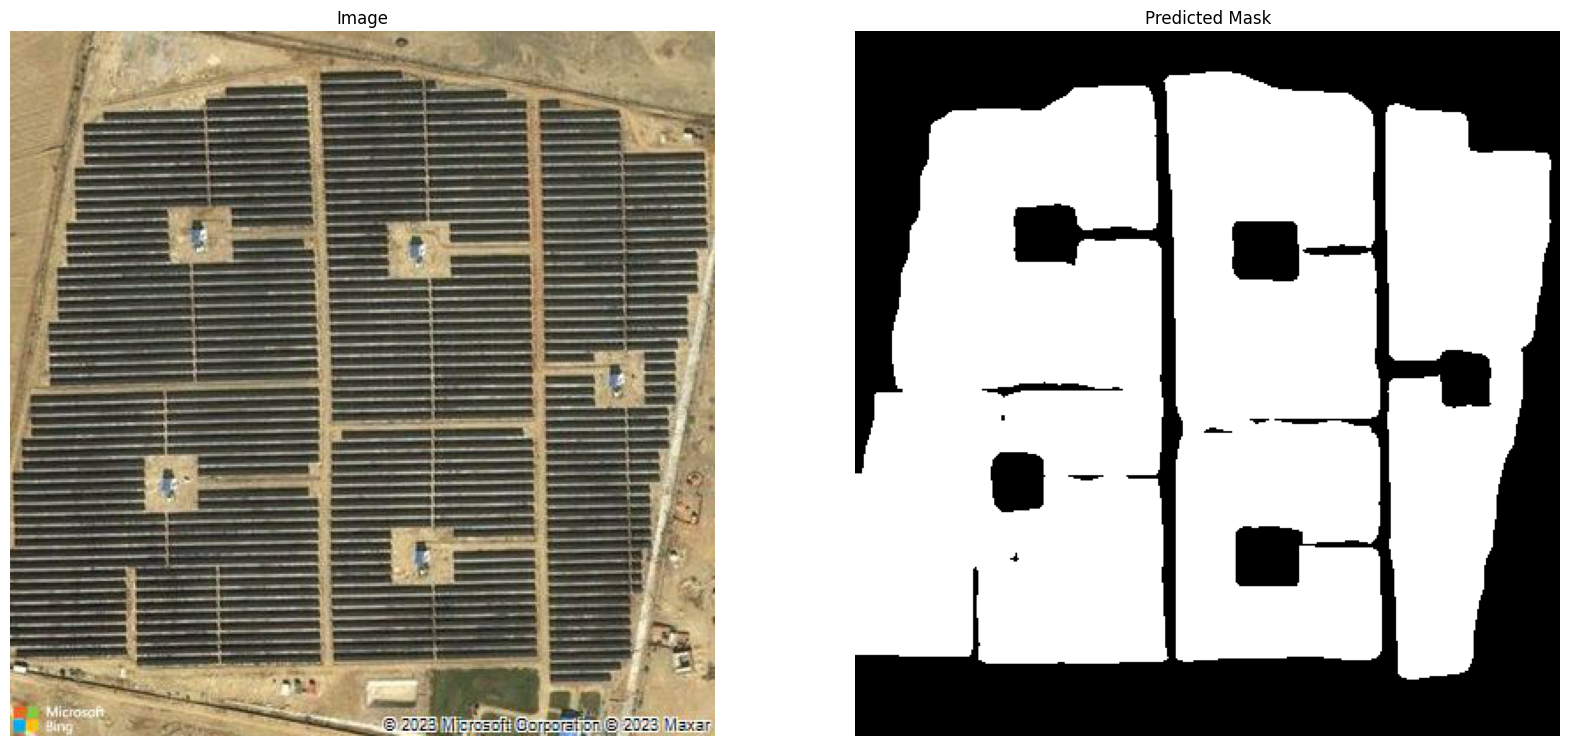

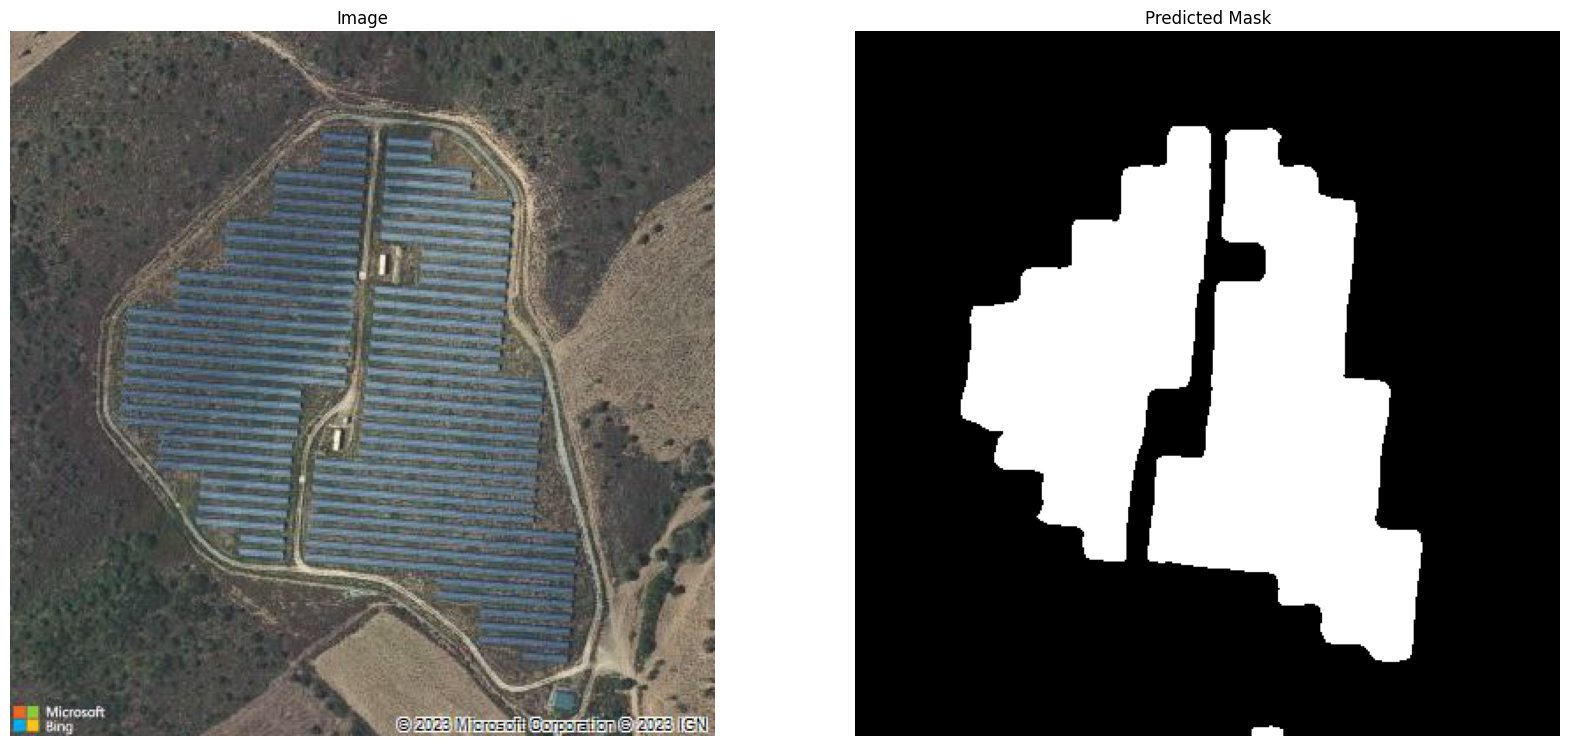

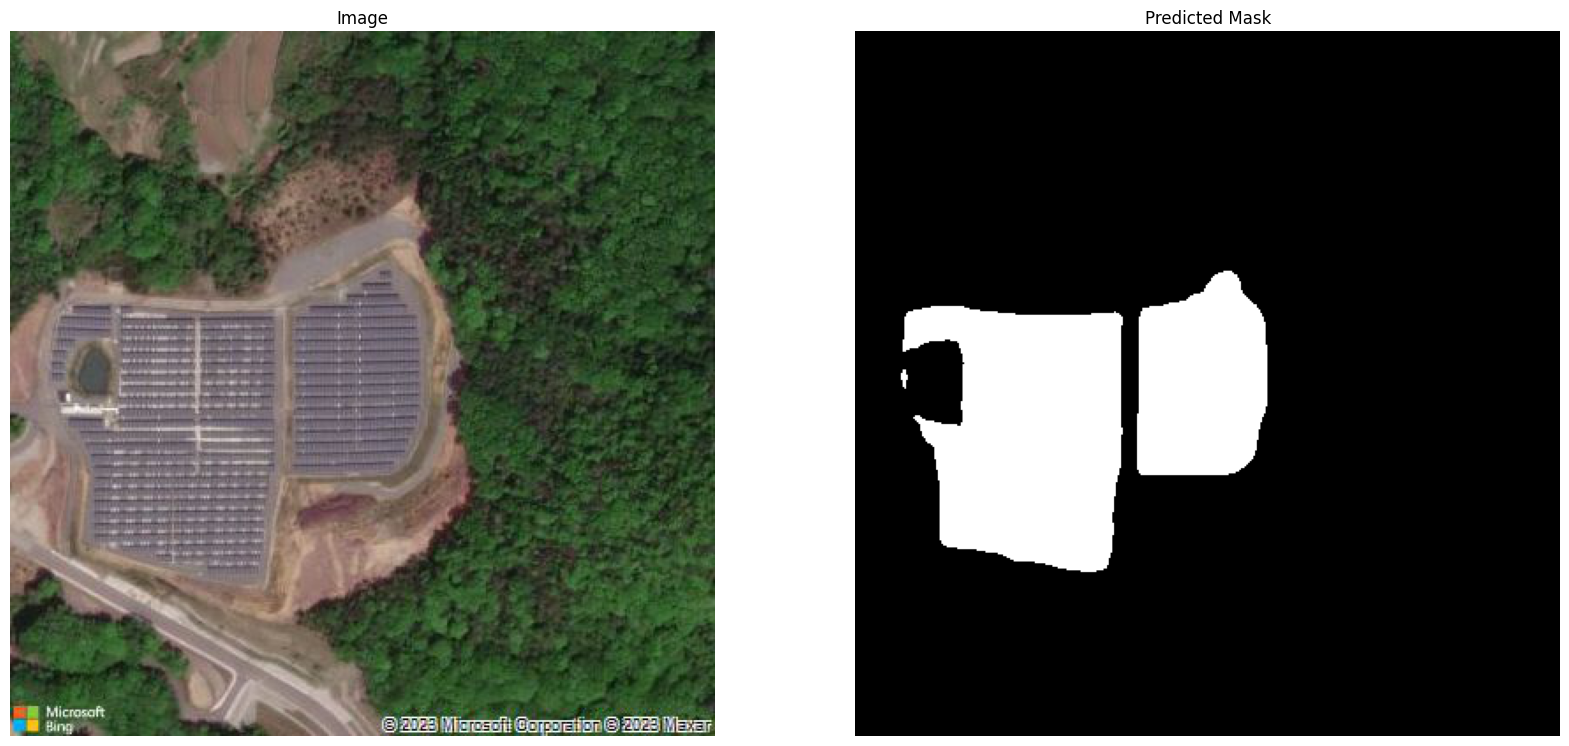

In [8]:
for file in file_list:
  image =  Image.open(file)
  predict_segmentation(model, image)
